# What is the fastest possible volleyball serve?

**A computational essay by Karl Henrik Fredly, undergraduate at the University of Oslo (karlhf@student.uv.uio.no)**

When I was in high school I really liked playing volleyball. Getting a good serve, spike or block always felt great. Me and my friend Filip used to practice serving after school, hitting the ball back and forth. But his serves were always way better than mine, having much more power and spin. On the court his serves were an absolute pain to return, while mine were just decent. I could never quite figure it out. But maybe I can now? By using my knowledge about physics and computation, can I find out what it takes to make the fastest possible serve? It's worth a shot.

To do the calculations I will use numpy. And to show my results I will use matplotlib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The rules

In volleyball, the goal is to make the ball hit the floor on your opponents side of the net. The strategy then, is to make it as hard as possible for the opponent to catch the ball, often by setting up for a spike by the net after your team catches the ball. To get the ball into play, you serve the ball from behind the court, over to your opponents side, where they try to catch it. It is beneficial to also make their initial catch of the ball as difficult as possible, either by making the serve fast or unpredictable.

When I say "the fastest possible serve", what I mean is the serve that spends the least amount of time in the air before hitting the opponents floor, giving my opponents the smallest amount of time possible to react to my serve.

Before I tackle the problem, I'll need to define some parameters, as the court, net, ball and air will affect the outcome of the serve. Information about the court, net and ball were taken from the <a href="https://www.fivb.org/EN/Refereeing-Rules/documents/FIVB-Volleyball_Rules_2017-2020-EN-v06.pdf">FIVB</a>.

A volleyball court is 18m by 9m, and the net has a height of 2.43m, standing tall in the middle of the court. The ball weighs 270g, and has a radius of 10,5cm.

In [2]:
outX = 18
netX = 9
netheight = 2.43
ballmass = 0.265
radius = 0.105
A = np.pi * radius**2 #Cross sectional area

<img src="Resources/VolleyballResources/Overview.jpg" alt="Drawing" style="width: 50%;"/>

Womens volleyball semifinals - Source: <a href="https://www.flickr.com/photos/paulsimpson1976/7748398084/in/photostream/">Paul Simpsons</a>.

## The forces acting on the ball

In order to find the fastest possible serve, I'll have to know how the ball moves through the air. The things that affect the movement of the ball are the initial conditions of the serve, and the forces acting on the ball. I'll define the forces first.

### Gravity

Throughout the serve, gravity will apply a constant force on the ball, pulling it down. At sea level, the force is given by $G = mg$, with $m$ being the mass of the ball, and $g$ being the standard acceleration due to gravity. Newtons second law gives us that force equals mass times acceleration, which means that:

$$F = ma \Rightarrow a = \frac{F}{m} = \frac{G}{m} = \frac{mg}{m} = g$$

This means that gravity will constantly give an acceleration of $g = 9.81 m/s^2$ downward.

In [3]:
g = [0, -9.81] #I'm calculationg the movement of the ball in two dimentions, and gravity only works in the vertical direction

### Air resistance

When the ball moves through the air, it has to move away the air in front of it. When the ball pushes away the air, the air pushes the ball back, slowing the ball down. How much the ball is pushed back relies on the velocity of the ball, the size of the ball, the density of the air and something called the drag coefficient of the ball. The drag coefficient of objects is normally found experimentally. I will be using the drag coefficient found by the brilliant people at <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.176.6783&rep=rep1&type=pdf">Hope College</a> when solving a similar problem to mine.

Drag acts in the direction opposite of the velocity of the ball, and is at high velocities given by:

$$\vec{F}_{Drag} = -\frac{1}{2}\vec{v}^2\rho C_d A$$

where $\vec{v}$ is the velocity and $C_d$ is the drag coefficient.

In [4]:
rho = 1.225 #The density of the air
Cd = 0.36 #Drag coefficient of a volleyball
def drag(v):
    return -0.5 * v * np.linalg.norm(v) * rho * Cd * A

### Spin - The Magnus Effect

When the ball flies through the air, air is flowing past the ball. If the ball has top-spin, the top of the ball will move along the direction the ball is moving, pushing air in the direction opposite of the flow. This will make air accumulate at the top of the ball. On the bottom of the ball, the spinning of the ball will simply push the air in the same direction as the flow.

This means that air will accumulate at the top of the ball, but not at the bottom. This will result in a difference in pressure, which will push the ball downward.

<img src="Resources/VolleyballResources/MagnusEffect.jpg" alt="Drawing" style="width: 50%;"/>

This downward force due to spin will be beneficial to my perfect serve, as it will make the ball move faster toward the ground. This force due to spin relies on the angular velocity, velocity, cross-sectional area and radius of the ball, as well as something called the spin coefficient. Again, this value is normally found experimentally, and I will again use the results found by Hope College for my calculation.

The force due to spin is perpendicular to the velocity of the ball, and is given by:

$$\vec{F}_{Spin} = \frac{1}{2}\vec{\omega} \times \vec{v} C_s \rho A r$$

where $\vec\omega$ is angular velocity and $C_s$ is the spin-coefficient.

In [5]:
spinCoef = 0.30
def spinDrag(v, angvel):
    return 0.5 * spinCoef * rho * A * radius * angvel * np.array([v[1], -v[0]])

## Server constants

I'll need to put some constraints on the model, as I can't jump all the way to the net and smash the volleyball through Filip's face at the speed of light. The spin I hit the ball with, and maximum velocity also need to be limited. The values I set as my limitations will be my guesses at what a professional volleyball player can achieve.

In [6]:
startingPos = [0, 2.5] #I hit the ball at a height of 2.5m
angvel = 7*2*np.pi #7 revolutions/second, this is quite exaggerated, though I have no idea what is realistic
maxVel = 30 #m/s
maxAngle = np.pi/2 #pi/2 radians, 90 degrees

The ball will be served straight forward, along the edge of the court, meaning I will not look into the effect of serving diagonally. This is a big simplification, making the solving of the problem much easier to visualize.

This leaves me with two values to optimize: Starting velocity and angle upward. Before I try to find the combination of these two values that give me the fastest serve, I will make a function that takes a starting velocity and angle as parameters, and then computes the serve.

## Computing a serve

The function needs to do two things: Calculate the movement of the ball, and find when the ball hits the ground, the net or goes out of bounds. Calculating the movement is done with the Euler-Cromer method.

For every time step in the Euler-Cromer method, it will do a series of checks to find when the serve is successful or invalid:

A serve is successful if it hits the ground in bounds behind the net. However, if it collides with the net, or goes directly under the net during the serve, it is invalid. Hitting the ground on my side of the net or outside the court will also invalidate the serve.

In [7]:
#Takes initial conditions and parameters for the Euler-Cromer loop, and returns ball trajectory and serve time
def serve(startingVel, startingAng, n, dt):
    v = np.array([startingVel*np.cos(startingAng), startingVel*np.sin(startingAng)])
    p = np.empty((num,2))
    p[:] = np.nan #Makes the position array empty so that the (0,0)-position donesn't show up on the plot
    p[0] = startingPos
    
    #The Euler-Cromer loop
    for i in range(n):
        a = g + drag(v)/ballmass + spinDrag(v, angvel)/ballmass
        v = v + a*dt
        p[i+1] = p[i] + v*dt
        
        #Checking if the ball is in a critical region
        distance = p[i+1][0]
        height = p[i+1][1]
        if (distance < outX and height < radius and distance > netX + 0.5):
            #It hit the ground on the other side of the net, a seccessful serve!
            return(p, i * dt) #I return an array with every position the ball was at, and the time the serve took
        if (distance > outX or height < radius):
            #It's out of bounds or it hit the ground on my side of the net
            return(p, None)
        if ((p[i][0] <= netX <= distance) and height < netheight + radius):
            #It's below the net
            return(p, None)
    return(p, None) #In case the serve never lands

Note that the function return the trajectory of the ball, along with the time of the serve if it was successful.

### Test run

Before I try to find the optimal velocity and starting angle, I will compute an average serve as a starting off point for further analysis.

First I define the number of iterations and the time-step for the Euler-Cromer calculation. Then I define the starting velocity and angle, and finally I call my function to compute the serve.

In [8]:
num = 2000
timestep = 0.001
v0 = 17 #m/s
theta0 = 0.32 #starting angle in radians
examplePosition, exampleTime = serve(v0, theta0, 2000, 0.001)

Plotting the example serve:

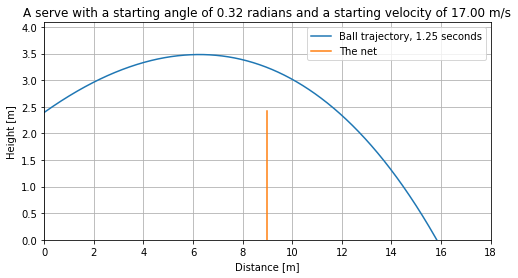

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(examplePosition[:, 0], examplePosition[:, 1] - radius, label="Ball trajectory, {:.2f} seconds".format(exampleTime or 0))
plt.xlim(0, outX)
plt.ylim(0, np.nanmax(examplePosition[:,1])+0.5)
plt.plot([9,9],[0,netheight], label="The net")
plt.grid()
plt.legend(loc="upper right")

plt.title("A serve with a starting angle of {:.2f} radians and a starting velocity of {:.2f} m/s".format(theta0, v0))
plt.xlabel("Distance [m]")
plt.ylabel("Height [m]")
plt.show()

Now that I have the tools to simulate a serve and see if it was valid, it's time to see how the starting speed and angle affect the trajectory an total airtime.

## Finding the effect of changing speed and angle

I'll use my example serve as a starting off point and see what happens if I change the angle of the serve, and then the velocity.

### Changing angle

My intuition tells me that I'll want to go for as low an angle as possible, as that will make the arch of the ball lower, and therefore make the journey from the air to the ground as short as possible. By keeping the velocity steady at 16m/s and calculating the time it would take for a serve at any angle between 0 and $\pi$/2 radians (0 and 90 degrees) I can see what difference changing the angle makes to the total time of the serve.

In [10]:
thetas = np.linspace(0, np.pi/2, 100)
thetime = np.empty(100)
thetime[:] = np.nan
n = 2000
dt = 0.005
constVel = 17

for i in range(len(thetas)):
    theta = thetas[i]
    thetime[i] = serve(constVel, theta, n, dt)[1]

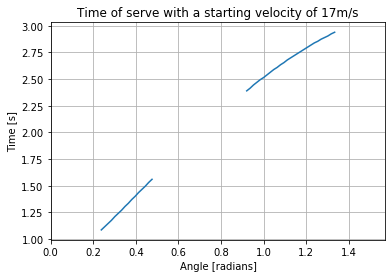

In [11]:
plt.plot(thetas, thetime)
plt.xlim(0,np.pi/2)
plt.grid()
plt.title("Time of serve with a starting velocity of 17m/s")
plt.xlabel("Angle [radians]")
plt.ylabel("Time [s]")
plt.show()

It looks like my intuition was right, lower angle means shorter total time. I see that a small change in angle can mean a large change in total time, which means that optimizing the angle of the serve is very beneficial for getting faster serves.  But there is a limit to how low the ball can be served, I see that the graph cuts off at about 0.25 radians at the optimal time of about 1.1 seconds. The gap in the middle of the graph is due to the ball flying too far. The serves with low angles are close to the net and hit the ground with a high horizontal velocity, while the serves with high angles fly far above the net and don't go as far horizontally as a result. Between these extremes are serves that are more optimized for distance, and thus fly out of bounds.

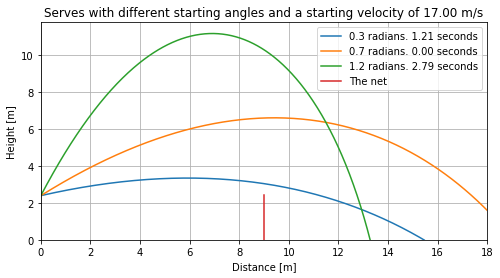

In [12]:
pos1, time1 = serve(constVel, 0.3, n, dt)
pos2, time2 = serve(constVel, 0.7, n, dt)
pos3, time3 = serve(constVel, 1.2, n, dt)

plt.figure(figsize=(8, 4))
plt.plot(pos1[:, 0], pos1[:, 1] - radius, label="0.3 radians. {:.2f} seconds".format(time1 or 0))
plt.plot(pos2[:, 0], pos2[:, 1] - radius, label="0.7 radians. {:.2f} seconds".format(time2 or 0))
plt.plot(pos3[:, 0], pos3[:, 1] - radius, label="1.2 radians. {:.2f} seconds".format(time3 or 0))
plt.xlim(0, outX)
plt.ylim(0, np.nanmax(pos3[:,1])+0.5)
plt.plot([9,9],[0,netheight], label="The net")
plt.grid()
plt.legend(loc="upper right")

plt.title("Serves with different starting angles and a starting velocity of {:.2f} m/s".format(v0))
plt.xlabel("Distance [m]")
plt.ylabel("Height [m]")
plt.show()

It is obvious that serving with a low angle is the optimal strategy. High angled serves are much easier to catch due to the increased time to react, but also due to the ball coming in at an angle which is much easier to pass to the setter with a high angle.

### Changing velocity

To see how velocity changes the total time, I'll do the same as with the angles. With a constant angle of 0.32 radians I will calculate the time it takes for a serve at any velocity between 10 and 30m/s (the maximum velocity).

In [13]:
vels = np.linspace(10, maxVel, 100)
veltime = np.empty(100)
veltime[:] = np.nan
n = 2000
dt = 0.005
constAngle = 0.32

for i in range(len(vels)):
    vel = vels[i]
    veltime[i] = serve(vel, constAngle, n, dt)[1]

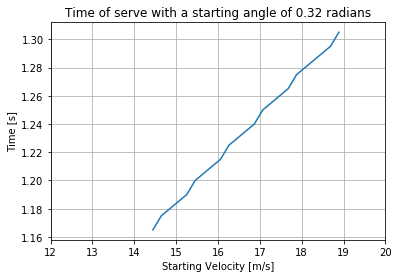

In [14]:
plt.plot(vels,veltime)
plt.xlim(12,20)
plt.grid()
plt.title("Time of serve with a starting angle of 0.32 radians")
plt.xlabel("Starting Velocity [m/s]")
plt.ylabel("Time [s]")
plt.show()

This isn't as intuitive. Lower starting velocity leads to faster serves. An important caveat here is that the angle is constant. The lowest speed leads to the lowest trajectory, which again reduces the distance from the ball to the ground. With the results for changing the angle and for changing the velocity, it seems like the best strategy is reaching as low an angle as possible, and then finding the lowest possible speed for that angle.

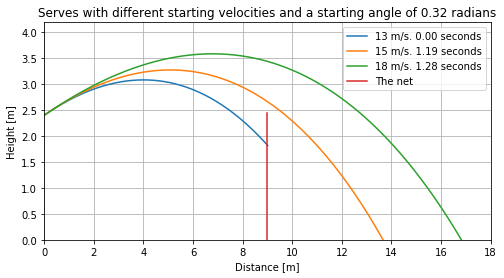

In [15]:
pos1, time1 = serve(13, constAngle, n, dt)
pos2, time2 = serve(15, constAngle, n, dt)
pos3, time3 = serve(18, constAngle, n, dt)

plt.figure(figsize=(8, 4))
plt.plot(pos1[:, 0], pos1[:, 1] - radius, label="13 m/s. {:.2f} seconds".format(time1 or 0))
plt.plot(pos2[:, 0], pos2[:, 1] - radius, label="15 m/s. {:.2f} seconds".format(time2 or 0))
plt.plot(pos3[:, 0], pos3[:, 1] - radius, label="18 m/s. {:.2f} seconds".format(time3 or 0))
plt.xlim(0, outX)
plt.ylim(0, np.nanmax(pos3[:,1])+0.5)
plt.plot([9,9],[0,netheight], label="The net")
plt.grid()
plt.legend(loc="upper right")

plt.title("Serves with different starting velocities and a starting angle of {:.2f} radians".format(constAngle))
plt.xlabel("Distance [m]")
plt.ylabel("Height [m]")
plt.show()

## Finding the fastest possible serve

So far I have changed the velocity and angle separately for a pretty average serve, to see what impact the changes make on the total airtime of the serve. However, to find the fastest possible serve I will need to find the combination of angle and velocity that results in the lowest possible time.

To find the best possible combination I will calculate an entire array of possible combinations and then find the fastest. There are more sophisticated methods to optimize two variable functions, but a brute force method will be used here due to the function not being very smooth.

I will try out 100 different angles and 100 different velocities. Totaling 10000 combination of angles and velocity, that is 10000 serves to calculate. To reduce the time of the calculation I will use a pretty big time-step in the Euler-Cromer loop. This results in a pretty rough estimation though. Greater accuracy can be achieved by trying more combinations in a smaller area with a more accurate Euler-Cromer calculation (which I will do later).

In [16]:
dim = 100 #Number of values to try
velocities = np.linspace(10, 30,dim) #All of the velocities I will try out
angles = np.linspace(0, np.pi/2, dim) #All of the angles I will try out

time = np.empty((dim, dim)) #The time each valid serve takes
time[:] = np.nan

In [17]:
n = 250
dt = 0.02

for j in range(len(velocities)):
    vel0 = velocities[j]
    for k in range(len(angles)):
        angle = angles[k]
        time[k][j] = serve(vel0, angle, n, dt)[1] #Saving the time the serve takes for later analysis

### The perfect combination of angle and velocity

With the calculation of 10000 different serves complete, all that's left to do is analyze the results and find the perfect combination.

First I'll make a contour plot of the combinations and complementary times to show how angle and velocity change the total time of the serve, as well as to show what combinations result in a successful serve.

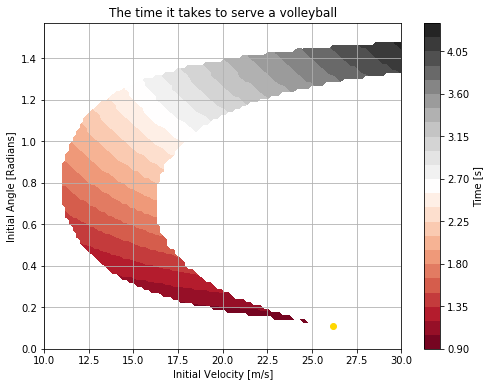

In [18]:
X, Y = np.meshgrid(velocities, angles)

plt.figure(figsize=(8, 6))
ax = plt.contourf(X, Y, time, 25, cmap='RdGy')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time [s]')

result = np.where(time == np.nanmin(time))
bvel = velocities[result[1][0]] #Best velocity
btheta = angles[result[0][0]] #Best angle
plt.plot(bvel,btheta,'o',color='#FFD700') #The yellow point on the plot

plt.grid()
plt.title("The time it takes to serve a volleyball")
plt.xlabel("Initial Velocity [m/s]")
plt.ylabel("Initial Angle [Radians]")
plt.show()

Every possible serve exists on a band which curves from high angle and high velocity(grey area), around low velocity medium angle(pink area), and ends with a sharp point at low angle, high velocity(red area, yellow dot). The yellow dot represents the optimal serve found. Around the optimal serve, there are so few possible serves that they don't show up on the plot at all. As one would expect, there is little room for error around the optimal serve, a slight change in velocity or angle, and the serve goes straight into the net or over the court.

In [19]:
print("""The fastest possible serve has a starting angle of {:.3f} radians, a starting velocity of {:.3f} m/s,
and takes {:.3f} seconds.""".format(btheta, bvel, np.nanmin(time)))

The fastest possible serve has a starting angle of 0.111 radians, a starting velocity of 26.162 m/s,
and takes 0.900 seconds.


### The fastest possible serve

By doing the calculation over a much smaller area, and with a much more accurate Euler-Cromer calculation, I found a slightly different fastest serve. This much more accurate calculation resulted in a serve which is slightly slower than the one found with the rough approximation. The different levels of accuracy resulted in different limits of what was possible. Although better accuracy didn't result in a faster serve, it resulted in a more realistic fastest serve, which is much more valuable.

With the best starting angle and velocity found, I can plot the trajectory of the fastest possible serve!

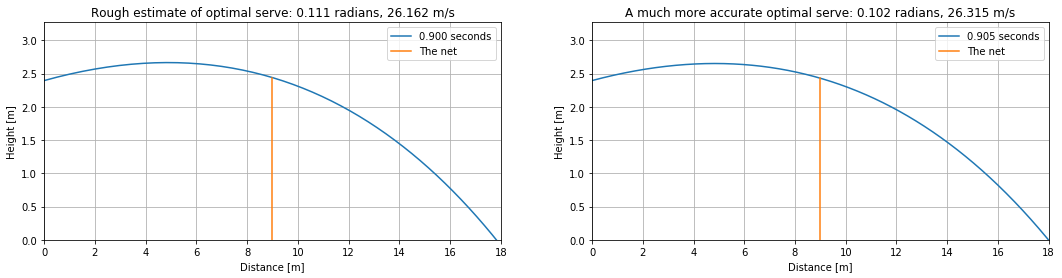

In [20]:
n = 250
dt = 0.02
bpos, btime = serve(bvel, btheta, n, dt)
vbpos, vbtime = serve(26.31515, 0.101717, 2000, 0.0005)

plt.figure(figsize=(18, 4))
plt.subplot(121)
plt.plot(bpos[:, 0], bpos[:, 1] - radius, label="{:.3f} seconds".format(btime or 0))
plt.xlim(0, outX)
plt.ylim(0, np.nanmax(bpos[:,1])+0.5)
plt.plot([9,9],[0,netheight], label="The net")
plt.grid()
plt.legend(loc="upper right")
plt.title("Rough estimate of optimal serve: {:.3f} radians, {:.3f} m/s".format(btheta, bvel))
plt.xlabel("Distance [m]")
plt.ylabel("Height [m]")

plt.subplot(122)
plt.plot(vbpos[:, 0], vbpos[:, 1] - radius, label="{:.3f} seconds".format(vbtime or 0))
plt.xlim(0, outX)
plt.ylim(0, np.nanmax(bpos[:,1])+0.5)
plt.plot([9,9],[0,netheight], label="The net")
plt.grid()
plt.legend(loc="upper right")
plt.title("A much more accurate optimal serve: {:.3f} radians, {:.3f} m/s".format(0.101717, 26.31515))
plt.xlabel("Distance [m]")
plt.ylabel("Height [m]")

plt.show()

There it is, the fastest possible serve. Flying only centimeters over the net, and landing right at the edge of the court, this serve leaves the minimal amount of time to react before landing on the floor. It looks like the optimal strategy is to shoot at the lowest possible angle, and with that angle shoot at the lowest possible velocity. When this strategy is taken to the extreme, the ball barely gets above the net, and flies all the way to the back of the court. With this newfound knowledge in my arsenal I am
ready to claim my revenge against Filip.

The actual efficiency of such a serve is up for discussion, as where the ball lands in relation to the defenders is a big factor in the efficiency of the serve, along with the unpredictability of the serve. However, given the choice, I would definitely prefer not to be on the receiving end of the fastest possible serve.

## Sources and inspiration

Optimizing a Volleyball Serve - Hope College Mathematics REU Summer 06 - http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.176.6783&rep=rep1&type=pdf

The Magnus Effect - https://en.wikipedia.org/wiki/Magnus_effect

Volleyball Rules - https://www.fivb.org/EN/Refereeing-Rules/documents/FIVB-Volleyball_Rules_2017-2020-EN-v06.pdf